In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#preprocessing ops
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.utils import resample
# DL ops
import tensorflow as tf

from keras import backend as K
from keras.models import Sequential
from tensorflow.keras.utils import plot_model
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.noise import GaussianNoise
from keras.layers.advanced_activations import PReLU
from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical

from tensorflow.keras import regularizers, metrics, losses

from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [3]:
def string_to_num(y):
  if y == 'low':
    return 0
  if y == 'mid':
    return 1
  if y == 'high':
    return 2

In [38]:
X = pd.read_csv('/gdrive/MyDrive/text_mining/project/all_cond_polarities.csv')
y = pd.read_csv('/gdrive/MyDrive/text_mining/project/y.csv')

y['label'] = y['label'].apply(lambda x: string_to_num(x))

# DNN Sentcnet

In [39]:
is_NaN = X.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = X[row_has_NaN]
na_rows = rows_with_NaN.index.to_list()

In [40]:
#drop NA 
X = X.drop(na_rows)
y = y.drop(na_rows)

In [41]:
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)


for train_index, test_index in sss.split(X, y):
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=456)

y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)
y_val = to_categorical(y_val, 3)


In [42]:
initializer = tf.keras.initializers.RandomUniform(minval=0., maxval=1., seed=123)

kernel_initializer=None
kernel_regularizer=None
bias_regularizer=None

n_features = X_train.shape[1]
model = Sequential()

# FC @ 32, non-linear
model.add(Dense(128, activation= "relu" , input_shape=(n_features,), kernel_initializer=kernel_initializer, kernel_regularizer=kernel_regularizer, bias_regularizer=bias_regularizer))
model.add(Dropout(0.2))
# FC @ 16, non-linear
model.add(Dense(64, activation = "relu",  kernel_initializer=kernel_initializer, kernel_regularizer=kernel_regularizer, bias_regularizer=bias_regularizer))
model.add(Dropout(0.2))

# output layer (nb_classes)
model.add(Dense(3, activation = "sigmoid"))

from tensorflow.keras.optimizers import Adam # yet another way to set up optimizers explicitly --> https://keras.io/api/optimizers/
# compile: optimizer & losses/metrics
model.compile(optimizer = Adam(),
              loss = "binary_crossentropy",
              metrics = ["accuracy"]
              )


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               640       
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 3)                 195       
                                                                 
Total params: 9,091
Trainable params: 9,091
Non-trainable params: 0
_________________________________________________________________


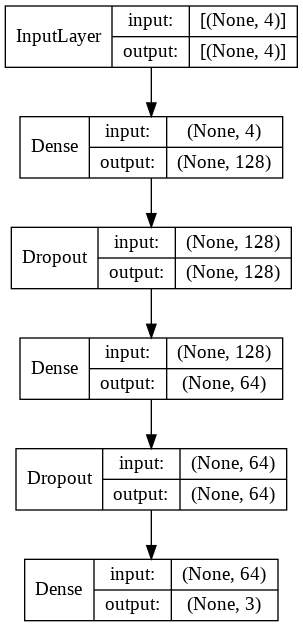

In [43]:

dot_img_file = '/tmp/model_1.png'
plot_model(model, to_file=dot_img_file, show_layer_names=False, show_shapes=True,rankdir='TB')

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(X_test.shape)

(69312, 4)
(69312, 3)
(7702, 4)
(7702, 3)
(19254, 4)
(19254, 4)


In [ ]:
#train!
# 150 epochs, gradient batched each 256 samples

batch_size = 64
n_epochs = 150

stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)


history = model.fit(X_train, 
                      y_train, 
                      batch_size=batch_size, 
                      epochs=n_epochs, 
                      verbose=1, 
                      validation_data=(X_val, y_val),
                      callbacks=[stop_callback])

Epoch 1/150
1083/1083 [==============================] - 6s 4ms/step - loss: 0.9852 - accuracy: 0.3728 - val_loss: 0.6318 - val_accuracy: 0.3960
Epoch 2/150
1083/1083 [==============================] - 4s 4ms/step - loss: 0.6375 - accuracy: 0.3886 - val_loss: 0.6313 - val_accuracy: 0.3977
Epoch 3/150
1083/1083 [==============================] - 4s 4ms/step - loss: 0.6335 - accuracy: 0.3887 - val_loss: 0.6305 - val_accuracy: 0.3970
Epoch 4/150
1083/1083 [==============================] - 4s 4ms/step - loss: 0.6321 - accuracy: 0.3899 - val_loss: 0.6295 - val_accuracy: 0.3977
Epoch 5/150
1083/1083 [==============================] - 4s 4ms/step - loss: 0.6313 - accuracy: 0.3899 - val_loss: 0.6291 - val_accuracy: 0.3970
Epoch 6/150
1083/1083 [==============================] - 5s 5ms/step - loss: 0.6308 - accuracy: 0.3902 - val_loss: 0.6286 - val_accuracy: 0.3970
Epoch 7/150
1083/1083 [==============================] - 4s 4ms/step - loss: 0.6306 - accuracy: 0.3900 - val_loss: 0.6284 - val_ac

In [ ]:
# quickly get the performance score
score = model.evaluate(X_val, y_val, batch_size=batch_size)

121/121 [==============================] - 1s 6ms/step - loss: 0.6282 - accuracy: 0.3967


In [ ]:
# quickly get the performance score
score = model.evaluate(X_test, y_test, batch_size=batch_size)

301/301 [==============================] - 2s 7ms/step - loss: 0.6300 - accuracy: 0.3907


# SVM (very slow)

In [ ]:
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)


for train_index, test_index in sss.split(X, y):
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]


In [ ]:
y_train.values.ravel()

array([1, 1, 2, ..., 0, 1, 1])

In [ ]:
from sklearn import svm

clf = svm.SVC()
clf.fit(X_train.values, y_train.values.ravel())

SVC()

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(X_test)

pcax = pca.transform(X_test)

In [ ]:
pcax

array([[-0.22538763, -0.06746866],
       [-0.17054002, -0.07512617],
       [-0.05115886,  0.11846703],
       ...,
       [ 0.15192606, -0.32244924],
       [-0.0954572 ,  0.06988371],
       [-0.21678035, -0.05169699]])

In [ ]:
def set_color(x):
  if x == 0:
    return 'r'
  if x == 1:
    return 'g'
  if x == 2:
    return 'b'

In [ ]:
clf.predict(np.array([X_test.iloc[0]]))

array([1])

In [ ]:
acc = [1 for i in range(len(X_test)) if clf.predict(np.array([X_test.iloc[i]]))[0] == y_test.values[i][0]]

print(len(acc)/len(X_test))

0.39415186454762646


display svc on test with pred labels

In [ ]:
pred_color = [set_color(clf.predict(np.array([X_test.iloc[x]]))[0]) for x in range(len(X_test))]

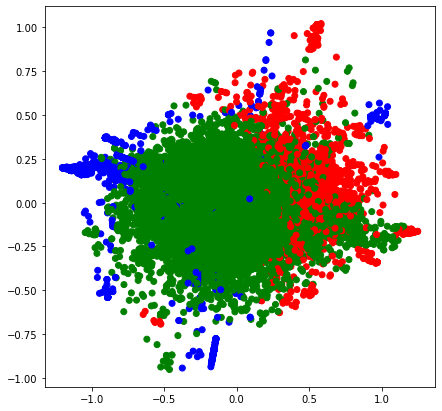

In [ ]:
plt.rcParams["figure.figsize"] = (7,7)
plt.scatter(pcax[:, 0],pcax[:, 1], color=pred_color)

# DNN with TfIdf features

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [18]:
import codecs
with codecs.open('/gdrive/MyDrive/text_mining/project/all_reviews.txt', 'r',encoding='latin1') as f:
    txt = f.read()

#print(txt)
X = txt.split('\n')


# #X = np.load('/gdrive/MyDrive/text_mining/project/all_reviews.npy', allow_pickle=True)
empty_index = np.load('/gdrive/MyDrive/text_mining/project/empty_inx.npy', allow_pickle=True)
y = pd.read_csv('/gdrive/MyDrive/text_mining/project/y.csv')

X = [ x.replace('\r','') for x in X]
X = [x for i, x in enumerate(X) if x != '']

y['label'] = y['label'].apply(lambda x: string_to_num(x))

#drop NA 
y = y.drop(empty_index)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=456)

y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)
y_val = to_categorical(y_val, 3)


Tf Idf

In [32]:
embedding_size = 500

tfidf_vect = TfidfVectorizer(min_df=5, max_features=embedding_size)
X_train_tfidf = tfidf_vect.fit_transform(X_train).toarray()

X_test_tfidf = tfidf_vect.transform(X_test).toarray()
X_val_tfidf = tfidf_vect.transform(X_val).toarray()

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)


In [33]:
vocab_size = len(tokenizer.word_index) + 1

input_tfidf = tf.keras.layers.Input(shape=(embedding_size,))

model = Dense(512,input_shape=(embedding_size,))(input_tfidf)
model = Dropout(0.2)(model)
model = Activation('relu')(model)
model = Dense(128)(model)
model = Dropout(0.2)(model)
model = Activation('relu')(model)
model = Dense(3, activation='sigmoid')(model)

model = tf.keras.models.Model(inputs=input_tfidf, outputs=model)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 500)]             0         
                                                                 
 dense_10 (Dense)            (None, 512)               256512    
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 activation_4 (Activation)   (None, 512)               0         
                                                                 
 dense_11 (Dense)            (None, 128)               65664     
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 activation_5 (Activation)   (None, 128)               0   

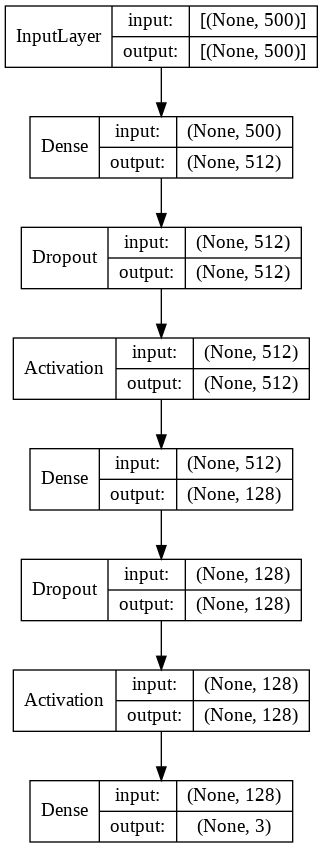

In [34]:

dot_img_file = '/tmp/model_1.png'
plot_model(model, to_file=dot_img_file, show_layer_names=False, show_shapes=True,rankdir='TB')

In [ ]:
X_train_tfidf.shape

(70816, 300)

In [ ]:
#train!
# 150 epochs, gradient batched each 256 samples

batch_size = 256
n_epochs = 150

stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


history = model.fit(X_train_tfidf,
                      y_train, 
                      batch_size=batch_size, 
                      epochs=n_epochs, 
                      verbose=1, 
                      validation_data=(X_val_tfidf, y_val),
                      callbacks=[stop_callback])

Epoch 1/150
277/277 [==============================] - 6s 18ms/step - loss: 0.5922 - accuracy: 0.4797 - val_loss: 0.5689 - val_accuracy: 0.5220
Epoch 2/150
277/277 [==============================] - 4s 16ms/step - loss: 0.5688 - accuracy: 0.5228 - val_loss: 0.5665 - val_accuracy: 0.5234
Epoch 3/150
277/277 [==============================] - 5s 16ms/step - loss: 0.5575 - accuracy: 0.5390 - val_loss: 0.5663 - val_accuracy: 0.5133
Epoch 4/150
277/277 [==============================] - 5s 18ms/step - loss: 0.5386 - accuracy: 0.5673 - val_loss: 0.5684 - val_accuracy: 0.5182
Epoch 5/150
277/277 [==============================] - 5s 18ms/step - loss: 0.5085 - accuracy: 0.6093 - val_loss: 0.5787 - val_accuracy: 0.5088
Epoch 6/150
277/277 [==============================] - 5s 17ms/step - loss: 0.4702 - accuracy: 0.6532 - val_loss: 0.6001 - val_accuracy: 0.5062


In [ ]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test_tfidf)
target_names = ['low', 'mid', 'high']
print(classification_report(np.argmax(y_test, axis =1), np.argmax(y_pred, axis =1 ), target_names=target_names))

              precision    recall  f1-score   support

         low       0.55      0.54      0.55      5825
         mid       0.50      0.56      0.53      7820
        high       0.49      0.42      0.45      6027

    accuracy                           0.51     19672
   macro avg       0.51      0.51      0.51     19672
weighted avg       0.51      0.51      0.51     19672



# DNN with TfIdf features & embeddings

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [26]:
import codecs
with codecs.open('/gdrive/MyDrive/text_mining/project/all_reviews.txt', 'r',encoding='latin1') as f:
    txt = f.read()

#print(txt)
X = txt.split('\n')


# #X = np.load('/gdrive/MyDrive/text_mining/project/all_reviews.npy', allow_pickle=True)
empty_index = np.load('/gdrive/MyDrive/text_mining/project/empty_inx.npy', allow_pickle=True)
y = pd.read_csv('/gdrive/MyDrive/text_mining/project/y.csv')

X = [ x.replace('\r','') for x in X]
X = [x for i, x in enumerate(X) if x != '']

y['label'] = y['label'].apply(lambda x: string_to_num(x))

#drop NA 
y = y.drop(empty_index)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=456)

y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)
y_val = to_categorical(y_val, 3)


Tf Idf

In [28]:
embedding_size = 500

tfidf_vect = TfidfVectorizer(min_df=5, max_features=embedding_size)
X_train_tfidf = tfidf_vect.fit_transform(X_train).toarray()

X_test_tfidf = tfidf_vect.transform(X_test).toarray()
X_val_tfidf = tfidf_vect.transform(X_val).toarray()

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

maxlen = 50

sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_train = pad_sequences(sequences_train, maxlen=maxlen)

sequences_test = tokenizer.texts_to_sequences(X_test)
sequences_test = pad_sequences(sequences_test, maxlen=maxlen)

sequences_val = tokenizer.texts_to_sequences(X_val)
sequences_val = pad_sequences(sequences_val, maxlen=maxlen)

In [29]:
vocab_size = len(tokenizer.word_index) + 1

input_tfidf = tf.keras.layers.Input(shape=(embedding_size,))
input_text = tf.keras.layers.Input(shape=(maxlen,))

embedding = tf.keras.layers.Embedding(vocab_size, embedding_size, input_length=maxlen)(input_text)

# this averaging method taken from:
# https://stackoverflow.com/a/54217709/1987598

mean_embedding = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x, axis=1))(embedding)

concatenated = tf.keras.layers.concatenate([input_tfidf, mean_embedding])

dense1 = Dense(1024)(concatenated)
dense1 = Dropout(0.3)(dense1)
dense1 = Activation('relu')(dense1)
dense1 = Dense(512)(dense1)
dense1 = Dropout(0.3)(dense1)
dense1 = Activation('relu')(dense1)
dense2 = Dense(128, activation='relu')(dense1)
dense3 = Dense(3, activation='softmax')(dense2)

model = tf.keras.models.Model(inputs=[input_tfidf, input_text], outputs=dense3)

model.summary()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 50, 500)      3614000     ['input_3[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 500)]        0           []                               
                                                                                                  
 lambda (Lambda)                (None, 500)          0           ['embedding[0][0]']              
                                                                                            

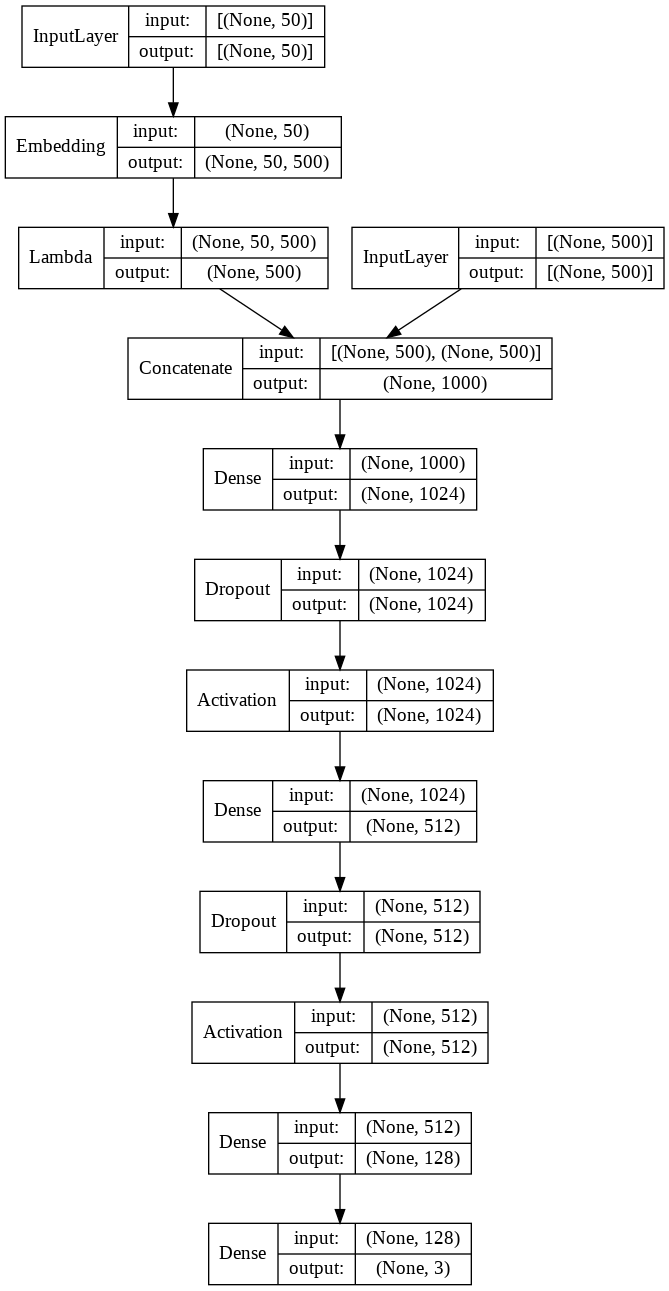

In [31]:

dot_img_file = '/tmp/model_1.png'
plot_model(model, to_file=dot_img_file, show_layer_names=False, show_shapes=True,rankdir='TB')

In [ ]:
#train!
# 150 epochs, gradient batched each 256 samples

batch_size = 1024
n_epochs = 150

stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


history = model.fit([X_train_tfidf, sequences_train],
                      y_train, 
                      batch_size=batch_size, 
                      epochs=n_epochs, 
                      verbose=1, 
                      validation_data=([X_val_tfidf, sequences_val], y_val),
                      callbacks=[stop_callback])

Epoch 1/150
70/70 [==============================] - 5s 30ms/step - loss: 0.6462 - accuracy: 0.3734 - val_loss: 0.6279 - val_accuracy: 0.3871
Epoch 2/150
70/70 [==============================] - 2s 24ms/step - loss: 0.6164 - accuracy: 0.4276 - val_loss: 0.5926 - val_accuracy: 0.5008
Epoch 3/150
70/70 [==============================] - 2s 23ms/step - loss: 0.5873 - accuracy: 0.4948 - val_loss: 0.5740 - val_accuracy: 0.5132
Epoch 4/150
70/70 [==============================] - 2s 23ms/step - loss: 0.5747 - accuracy: 0.5114 - val_loss: 0.5685 - val_accuracy: 0.5220
Epoch 5/150
70/70 [==============================] - 2s 24ms/step - loss: 0.5685 - accuracy: 0.5224 - val_loss: 0.5639 - val_accuracy: 0.5281
Epoch 6/150
70/70 [==============================] - 2s 24ms/step - loss: 0.5625 - accuracy: 0.5288 - val_loss: 0.5607 - val_accuracy: 0.5326
Epoch 7/150
70/70 [==============================] - 2s 24ms/step - loss: 0.5565 - accuracy: 0.5389 - val_loss: 0.5595 - val_accuracy: 0.5326
Epoch 

In [ ]:
from sklearn.metrics import classification_report

y_pred = model.predict([X_test_tfidf, sequences_test])
target_names = ['low', 'mid', 'high']
print(classification_report(np.argmax(y_test, axis =1), np.argmax(y_pred, axis =1 ), target_names=target_names))

              precision    recall  f1-score   support

         low       0.57      0.56      0.57      5825
         mid       0.51      0.57      0.54      7820
        high       0.51      0.45      0.48      6027

    accuracy                           0.53     19672
   macro avg       0.53      0.52      0.53     19672
weighted avg       0.53      0.53      0.53     19672

